#### B1 Topics — Alaz Sengul

***
###### Setup

Start off by importing the necessary libraries and tools.

In [3]:
import pandas # reading/maniuplating CSV files
import nltk # preprocessing
import spacy # preprocessing
import en_core_web_sm #Mina edit
import gensim # Latent Dirichlet Allocation
from pprint import pprint # pretty print

# plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

# analysis tools
import collections
import numpy as np

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

Define constants.

In [4]:
NUM_TOPICS = 4
ALPHA = 0.05
BETA = 0.05

Initialize spacy 'en' model.

In [5]:
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # keeping only tagger component for efficiency

nlp = en_core_web_sm.load(disable=['parser', 'ner'])# Mina edit

***
###### Data Compilation

Load the relevant meta and text data of the active grants, while extracting the relevant data rows.

In [6]:
db_meta = pandas.read_csv(r"B1_metadata.csv",
                         usecols = ['AID','FY','Funded','Competing',
                                    'RecomCode','IC','BudgetEnd','PCC'])

In [7]:
db_text = pandas.read_csv(r"B1_textdata.csv",
                         usecols = ['AID','T','A','N','S'])

The column 'PCC' contains a six-character string that indicates both PAC and PO. Add PAC and PO columns to reflect this identification.

In [8]:
db_meta['PAC'] = db_meta.PCC.str[:4] # create PAC column
db_meta['PO'] = db_meta.PCC.str[4:] # create PO column

Merge the two datasets by 'AID'. Filter by grants that are funded or are competing and have a RecomCode.

In [9]:
db = pandas.merge(db_meta, db_text, on='AID', how='left') # merges on 'AID'
db = db[(db.Funded == "Y") | ((db.Competing == "Y") & (pandas.notna(db.RecomCode)))] # active grants

Now that we have all our compiled data, we can do more filtering by ICs and PACs.

In [10]:
db = db[(db.IC == "GM")] # get rid of non-GM applications
db = db[(db.PAC != "B170")] # get rid of B170 PACs

You can also filter by dates.

In [11]:
db['BudgetEnd'] = pandas.to_datetime(db.BudgetEnd, format = "%m/%d/%Y", errors='coerce') # datetime
db = db[(db.FY >= 2018) | ((db.Funded == "Y") & (db.BudgetEnd > "2019-01-01"))]

Remove empty texts.

In [12]:
db = db[pandas.notna(db.A)] # remove if abstract is empty

Concatenate columns 'T', 'A', 'N', and 'S' to form long strings for each application, representing the document.

In [13]:
db['text'] = db['T'].map(str)+" "+db['A'].map(str)+" "+db['N'].map(str)+" "+db['S'].map(str)

Remove unnecessary columns.

In [14]:
db = db.drop(columns = ['FY','Funded','Competing','RecomCode','IC','BudgetEnd','PCC','T','A','N','S'])

In [15]:
db.head()

,AID,PAC,PO,text
33,9476252,B160,PB,Drug Effect Discovery Through Data Mining and ...
47,9470885,B301,LP,"Markov State Model approaches for folding, bin..."
67,9499981,B160,VR,Modeling the Risk of Lyme Disease in Built Env...
109,9500587,B120,VR,Novel Computational Techniques for Correlating...
111,9536067,B210,HR,Training Training Abstract\nMMBioS will contin...


***
###### Text Preprocessing

Clean up the text by stripping whitespace and keeping only letters.

In [16]:
db['text'] = db['text'].str.replace("[\n\xa0]", " ", regex=True).str.strip() # strip whitespace

In [17]:
db['text'] = db['text'].str.replace("[^A-Za-z ]+", "", regex=True) # keep only letters

Make all text lowercase.

In [18]:
db['text'] = db['text'].str.lower() # make all text lowercase

Only keep documents with unique text.

In [19]:
db = db.drop_duplicates(subset=['text'])

Load stopwords (http://www.ai.mit.edu/projects/jmlr/papers/volume5/lewis04a/a11-smart-stop-list/english.stop) and our own collection of words to remove.

In [20]:
with open("stopwords.txt") as f: # words loaded from local .txt file
    remove_words = [line.strip() for line in f if line.strip()]

Split the texts into lists of words. Also check against stopwords of the word's stem and remove. Here we apply Snowball Stemming (http://snowball.tartarus.org/texts/introduction.html).

In [21]:
sno = nltk.stem.SnowballStemmer('english') # import from nltk library

In [22]:
def stem_sentences(text): # helper function
    tokens = text.split()
    split_text = [t for t in tokens if sno.stem(t) not in remove_words]
    return(split_text)

In [23]:
db['text'] = db['text'].apply(stem_sentences) # apply function for each document

In [24]:
db.head(20)

,AID,PAC,PO,text
33,9476252,B160,PB,"[drug, effect, discovery, data, mining, integr..."
47,9470885,B301,LP,"[markov, state, approaches, folding, binding, ..."
67,9499981,B160,VR,"[risk, lyme, disease, built, environments, nor..."
109,9500587,B120,VR,"[computational, techniques, correlating, micro..."
111,9536067,B210,HR,"[training, training, abstract, mmbios, continu..."
120,9489276,B301,LP,"[molecular, basis, receptorligand, recognition..."
122,9472352,B120,VR,"[hardening, gromacs, molecular, simulation, en..."
123,9469533,B150,HR,"[information, integration, energy, expenditure..."
124,9497470,B301,LP,"[dynamic, ensembles, intrinsically, disordered..."
155,8957587,B301,LP,"[enhanced, silico, identification, targeted, i..."


***
Build a bigram model of the texts.

In [25]:
texts = db.text.values.tolist() # creates text_values variable

In [26]:
bigram_phrases = gensim.models.Phrases(texts, min_count=5, threshold=100)
bigram_phraser = gensim.models.phrases.Phraser(bigram_phrases)

In [27]:
bigrams = [bigram_phraser[doc] for doc in texts] # form bigrams

Lemmatize the words of the text, while only including nouns and verbs.

In [28]:
def lemmatization(texts, allowed_postags=['NOUN', 'VERB']): # helper fuction
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) # spacy function
        texts_out.append([token.lemma_ for token in doc]) #if token.pos_ in allowed_postags]) # This gets rid of many things
    return(texts_out)

In [29]:
texts = lemmatization(bigrams)

In [30]:
with open("lemma_stopwords.txt") as f: # words loaded from local .txt file
    remove_words = [line.strip() for line in f if line.strip()]
    remove_words = []

for i in range(len(texts)):
    for remove_word in remove_words:
        if remove_word in texts[i]:
            texts[i] = list(filter(lambda a: a != remove_word, texts[i]))
            #print(remove_word) 
    
texts[1][0:5]

['markov_state', 'approach', 'fold', 'bind', 'design']

***
###### Latent Dirichlet Allocation

Build a dictionary and corpus for use with LDA.

In [31]:
dictionary = gensim.corpora.Dictionary(texts)

In [32]:
corpus = [dictionary.doc2bow(text) for text in texts]

CONVERT THE NEXT CELL TO CODE TO RUN THE OPTIMIZATION ALGORITHM.  This may take hours, depending on your machine.

for t in [3, 4, 5, 6]:
    for i in [0.05, 0.1, 0.5, 1, 5]:
            for j in [0.05, 0.1, 0.5, 1, 5]:
                lda_model = gensim.models.LdaModel(corpus=corpus,
                                            num_topics=t,
                                            id2word=dictionary,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=20,
                                            passes=10,
                                            alpha=i,
                                            eta=j,
                                            iterations=1000,
                                            per_word_topics=True)
                print("N: " + str(t) + " ... Alpha: " + str(i) + " ... Beta: " + str(j))
                print(" -> Perplexity = ", lda_model.log_perplexity(corpus))
                coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_lda = coherence_model_lda.get_coherence()
                print(" -> Coherence Score = ", coherence_lda)
                print()

We see that the "best" model according to perplexity is N = 3, Alpha = 0.05, and Beta = 0.05.  However, we desire at least 4 topics, and thus we choose the model with N = 4, Alpha = 0.05, and Beta = 0.05.

Build the LDA model.

In [33]:
lda_model = gensim.models.LdaModel(corpus=corpus,
                                    num_topics=4,
                                    id2word=dictionary,
                                    random_state=100,
                                    update_every=1,
                                    chunksize=20,
                                    passes=10,
                                    alpha=0.05,
                                    eta=0.05,
                                    iterations=1000,
                                    per_word_topics=True)

Print perplexity and coherence score.

In [34]:
print("Perplexity =", lda_model.log_perplexity(corpus))

coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score =", coherence_lda)

Perplexity = -14.101436330466546
Coherence Score = 0.39928925968725404


Print top 10 words for each topic.

In [35]:
p_models = lda_model.show_topics(num_words=10, formatted=False)

In [36]:
pprint(p_models)

[(0,
  [('disease', 0.04960071),
   ('patient', 0.028840242),
   ('population', 0.027339885),
   ('health', 0.027121972),
   ('study', 0.022957904),
   ('predictive', 0.019929267),
   ('outcome', 0.018016132),
   ('treatment', 0.017427385),
   ('transmission', 0.016838435),
   ('infection', 0.01664983)]),
 (1,
  [('cell', 0.037677407),
   ('network', 0.01980725),
   ('disease', 0.019211678),
   ('gene', 0.016817957),
   ('study', 0.0165815),
   ('sequence', 0.015881496),
   ('human', 0.014353269),
   ('microbiome', 0.011943415),
   ('biological', 0.009983526),
   ('analysis', 0.009856406)]),
 (2,
  [('datum', 0.04914551),
   ('tool', 0.02230473),
   ('analysis', 0.018903948),
   ('software', 0.014632522),
   ('project', 0.013908196),
   ('data', 0.011706139),
   ('clinical', 0.011431328),
   ('biomedical', 0.011242711),
   ('improve', 0.009495707),
   ('system', 0.00942379)]),
 (3,
  [('protein', 0.029778015),
   ('structure', 0.014159313),
   ('interaction', 0.0120006045),
   ('dynami

***
###### Analysis

Add a column to the database that specifies the topic most likely to be associated to that row's document.

In [37]:
probable_topics = []

for index, row in db.iterrows():
    bow = dictionary.doc2bow(row['text'])
    t = lda_model.get_document_topics(bow)
    
    probs = [tple for tple in t]
    max_tple = max(probs, key=lambda x:x[1])
    probable_topics.append(max_tple[0])

db['topic'] = probable_topics

In [38]:
db.head()

,AID,PAC,PO,text,topic
33,9476252,B160,PB,"[drug, effect, discovery, data, mining, integr...",3
47,9470885,B301,LP,"[markov, state, approaches, folding, binding, ...",3
67,9499981,B160,VR,"[risk, lyme, disease, built, environments, nor...",2
109,9500587,B120,VR,"[computational, techniques, correlating, micro...",1
111,9536067,B210,HR,"[training, training, abstract, mmbios, continu...",2


POs on x-axis, # of grants on y-axis. Stacked bar graph.

In [39]:
po_dict = collections.defaultdict(list)

for index, row in db.iterrows():
    po = row['PO']
    topic = row['topic']
    po_dict[po].append(topic)

for key, value in po_dict.items():
    print(key + ": " + str(len(value)))

PB: 208
LP: 332
VR: 432
HR: 281


Sum up topic counts for each PO.

In [40]:
data_dict = collections.defaultdict(list)

for key, value in po_dict.items():
    c = collections.Counter(po_dict[key])
    
    for i in range(NUM_TOPICS):
        data_dict[key].append(c[i])

In [41]:
PO = []
t = []
n = []

for key, value in data_dict.items():
    for i in range(NUM_TOPICS):
        PO.append(key)
        t.append(i)
        n.append(value[i])

In [42]:
data = [PO, t, n]
PO_header = list(set(PO))

In [43]:
rows = np.array(data).T.tolist()
headers = ['Program Directors', 'Topic', '#']
df = pandas.DataFrame(rows, columns = headers)

df.head()
df.dtypes

Program Directors    object
Topic                object
#                    object
dtype: object

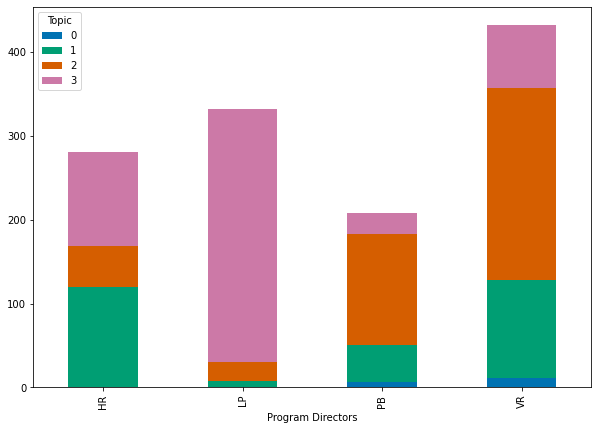

In [44]:
pivot_df = df.pivot(index='Program Directors', columns='Topic', values='#')

for i in range(4):
    pivot_df.iloc[:, i] = pandas.to_numeric(pivot_df.iloc[:, i])

pivot_df.plot.bar(stacked=True, figsize=(10,7))

***
###### Topic Visualizations

t-sne

In [45]:
# filtering by po
po_dict = {"HR": 0, "LP": 1, "PB": 2, "VR": 3}

po_num = []
for index, row in db.iterrows():
    po_num.append(po_dict[row['PO']])

print(len(po_num))

1253


In [46]:
# filtering by topics
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
arr = pandas.DataFrame(topic_weights).fillna(0).values
arr = arr[np.amax(arr, axis=1) > 0] # adjust threshold
topic_num = np.argmax(arr, axis=1)

print(len(topic_num))

1253


In [47]:
# build graph
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import numpy as np
import matplotlib.colors as mcolors

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
output_notebook()
n_topics = NUM_TOPICS
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1253 samples in 0.001s...
[t-SNE] Computed neighbors for 1253 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1253
[t-SNE] Computed conditional probabilities for sample 1253 / 1253
[t-SNE] Mean sigma: 0.064880
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.378601
[t-SNE] KL divergence after 1000 iterations: 0.566434


Loading BokehJS ...

In [48]:
# plot graph for topic filters
plot = figure(title="t-SNE Clustering of LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

# plot graph for po filters
plot = figure(title="t-SNE Clustering of Program Directors".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[po_num])
show(plot)

pyLDAvis

In [49]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.100101  0.054317       1        1  39.157822
2     -0.192350 -0.193814       2        1  28.658381
1     -0.026731  0.220772       3        1  26.079479
0      0.319182 -0.081275       4        1   6.104321, topic_info=           Term          Freq         Total Category  logprob  loglift
68      disease   5779.000000   5779.000000  Default  30.0000  30.0000
54        datum  11339.000000  11339.000000  Default  29.0000  29.0000
991        cell   7112.000000   7112.000000  Default  28.0000  28.0000
197     protein   8055.000000   8055.000000  Default  27.0000  27.0000
248       study   5873.000000   5873.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
440  prediction    444.074646   2117.046875   Topic4  -4.5535   1.2344
71       effect    402.749207   1851.780518   Topic4  -4.6512   1.2706
195     propose    423.526367   4821.850586   Topic4  -4.6009   0.3639
291    approach    409.385010   4151.333008   Topic4  -4.6348   0.4796
345     dynamic    391.856476   3531.322021   Topic4  -4.6786   0.5976

[260 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
808       2  0.999800         access
512       4  1.000369          adult
812       1  0.335968        advance
812       2  0.570232        advance
812       3  0.093705        advance
...     ...       ...            ...
2087      2  0.998790        vaccine
688       3  0.999247      variation
1746      3  0.226574          virus
1746      4  0.771081          virus
1826      3  0.999280  visualization

[377 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

***
###### Word Vectors

In [50]:
db['processed_text'] = texts

In [51]:
db.head()

,AID,PAC,PO,text,topic,processed_text
33,9476252,B160,PB,"[drug, effect, discovery, data, mining, integr...",3,"[drug, effect, discovery, datum, mining, integ..."
47,9470885,B301,LP,"[markov, state, approaches, folding, binding, ...",3,"[markov_state, approach, fold, bind, design, p..."
67,9499981,B160,VR,"[risk, lyme, disease, built, environments, nor...",2,"[risk, lyme, disease, build, environment, nort..."
109,9500587,B120,VR,"[computational, techniques, correlating, micro...",1,"[computational, techniques, correlating_microb..."
111,9536067,B210,HR,"[training, training, abstract, mmbios, continu...",2,"[training, training, abstract, mmbio, continue..."


In [52]:
topics_list = []

In [61]:
for t in lda_model.show_topics(num_words=10, formatted=False):
    t_list = []
    for w in t[1]:
        t_list.append(w)
    topics_list.append(t_list)
    
print(topics_list)
print(len(topics_list))
    

[[('disease', 0.04960071), ('patient', 0.028840242), ('population', 0.027339885), ('health', 0.027121972), ('study', 0.022957904), ('predictive', 0.019929267), ('outcome', 0.018016132), ('treatment', 0.017427385), ('transmission', 0.016838435), ('infection', 0.01664983)], [('cell', 0.037677407), ('network', 0.01980725), ('disease', 0.019211678), ('gene', 0.016817957), ('study', 0.0165815), ('sequence', 0.015881496), ('human', 0.014353269), ('microbiome', 0.011943415), ('biological', 0.009983526), ('analysis', 0.009856406)], [('datum', 0.04914551), ('tool', 0.02230473), ('analysis', 0.018903948), ('software', 0.014632522), ('project', 0.013908196), ('data', 0.011706139), ('clinical', 0.011431328), ('biomedical', 0.011242711), ('improve', 0.009495707), ('system', 0.00942379)], [('protein', 0.029778015), ('structure', 0.014159313), ('interaction', 0.0120006045), ('dynamic', 0.011604793), ('drug', 0.011233369), ('bind', 0.009956021), ('molecular', 0.0098042255), ('simulation', 0.009796691)

In [59]:
topics = []
for i in range(NUM_TOPICS):
    topics.append([])

for index, row in db.iterrows():
    topic = row['topic']
    topics[topic].append(row['processed_text'])
    
print(topics)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [57]:
from gensim.models import Word2Vec

models = []

for t in topics:
    models.append(Word2Vec(t))

Combine and format.

In [58]:
combined_list = []
for t in range(len(topics_list)):
    sub_list = []
    for w in topics_list[t]:
        similars = models[t].most_similar(positive=[w[0]], topn=10)
        sub_list.append((w[0], similars))
    combined_list.append(sub_list)

IndexError: list index out of range

In [79]:
pprint(combined_list)

[[('disease',
   [('transmission', 0.9902886152267456),
    ('datum', 0.9899731278419495),
    ('intervention', 0.9898767471313477),
    ('time', 0.9898668527603149),
    ('measle', 0.9897240400314331),
    ('risk', 0.9886634349822998),
    ('biomarker', 0.9886497259140015),
    ('infection', 0.9879155158996582),
    ('factor', 0.9877915978431702),
    ('epidemic', 0.9874793291091919)]),
  ('patient',
   [('propose', 0.991295337677002),
    ('transmission', 0.9912083148956299),
    ('study', 0.9911046624183655),
    ('datum', 0.990837037563324),
    ('risk', 0.9906517267227173),
    ('measle', 0.9893420934677124),
    ('treatment', 0.9892787933349609),
    ('biomarker', 0.9892067313194275),
    ('social', 0.9891880750656128),
    ('control', 0.9881547093391418)]),
  ('population',
   [('patient', 0.9872965216636658),
    ('measle', 0.9872666597366333),
    ('intervention', 0.9869620203971863),
    ('treatment', 0.9869066476821899),
    ('control', 0.9868558049201965),
    ('infection',